In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('ASIANPAINT.csv')
df

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ASIANPAINT,EQ,361.20,370.0,390.00,370.00,385.0,381.65,380.54,3318,1.262617e+11,NaN,NaN,NaN
1,2000-01-04,ASIANPAINT,EQ,381.65,380.0,392.00,375.00,390.0,385.55,383.50,4818,1.847699e+11,NaN,NaN,NaN
2,2000-01-05,ASIANPAINT,EQ,385.55,371.5,390.00,371.50,383.0,383.00,379.81,2628,9.981384e+10,NaN,NaN,NaN
3,2000-01-06,ASIANPAINT,EQ,383.00,384.9,384.90,374.50,375.1,377.50,379.88,3354,1.274114e+11,NaN,NaN,NaN
4,2000-01-07,ASIANPAINT,EQ,377.50,376.0,390.00,370.00,389.0,385.70,383.38,9589,3.676275e+11,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,ASIANPAINT,EQ,2517.95,2530.0,2575.00,2530.00,2558.0,2557.90,2557.47,1103980,2.823400e+14,58557.0,335232.0,0.3037
5302,2021-04-27,ASIANPAINT,EQ,2557.90,2545.0,2579.90,2534.00,2571.0,2574.35,2560.55,866331,2.218288e+14,66988.0,281178.0,0.3246
5303,2021-04-28,ASIANPAINT,EQ,2574.35,2588.0,2620.25,2575.00,2612.0,2614.55,2605.91,1065561,2.776752e+14,52622.0,449241.0,0.4216
5304,2021-04-29,ASIANPAINT,EQ,2614.55,2630.0,2642.00,2570.00,2613.0,2613.45,2607.33,1295346,3.377394e+14,64039.0,447979.0,0.3458


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
close_data = df['Close'].dropna()

In [4]:
df.shape

(5306, 14)

In [5]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,1247.000952,1247.683952,1264.625349,1230.900697,1247.317132,1247.410903,1247.799926,5.096721e+05,6.942919e+13,41346.011401,2.751281e+05,0.625572
std,1074.399506,1074.025577,1087.238871,1062.629409,1074.432667,1074.476439,1075.057438,8.535993e+05,1.443973e+14,36435.449733,4.157465e+05,0.187597
min,210.750000,210.000000,215.750000,204.000000,210.600000,210.750000,212.220000,2.500000e+01,1.278415e+09,70.000000,2.500000e+01,0.076800
25%,415.737500,415.000000,424.950000,410.000000,416.000000,416.262500,415.692500,1.370750e+04,7.538133e+11,16264.750000,1.262200e+04,0.486200
50%,889.375000,890.000000,903.975000,878.075000,890.000000,889.475000,888.350000,5.713600e+04,1.109437e+13,32402.500000,5.273800e+04,0.616100
75%,1599.037500,1599.800000,1629.675000,1573.037500,1602.500000,1600.762500,1600.982500,8.077905e+05,7.761479e+13,54727.500000,4.383750e+05,0.765500
max,5213.100000,5221.100000,5247.750000,5150.050000,5221.100000,5213.100000,5175.790000,1.154594e+07,2.216650e+15,351347.000000,7.938427e+06,1.000000


In [6]:
#Checking Stationarity using Augmented Dickey-Fuller (ADF) Test
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test
result = adfuller(close_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# Interpretation
if result[1] < 0.05:
    print("✅ Data is stationary (p < 0.05)")
else:
    print("⚠️ Data is non-stationary (p >= 0.05)")


ADF Statistic: -2.134728936884083
p-value: 0.23078109376737815
⚠️ Data is non-stationary (p >= 0.05)


In [7]:
# 📉 First order differencing
diff_data = close_data.diff().dropna()

# Run ADF test again on differenced data
from statsmodels.tsa.stattools import adfuller
result_diff = adfuller(diff_data)
print('ADF Statistic after differencing:', result_diff[0])
print('p-value:', result_diff[1])

if result_diff[1] < 0.05:
    print("✅ Differenced data is now stationary.")
else:
    print("⚠️ Still not stationary — try 2nd order differencing.")


ADF Statistic after differencing: -25.197407633129533
p-value: 0.0
✅ Differenced data is now stationary.


Best ARIMA order: (0, 1, 0)


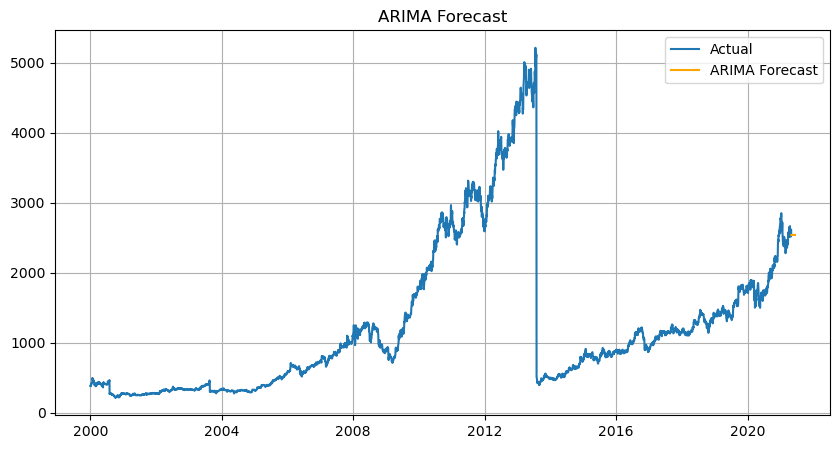

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.arima.model import ARIMA
import itertools

warnings.filterwarnings("ignore")

p = d = q = range(0, 3)  # 0 to 2
pdq = list(itertools.product(p, d, q))

best_score = float("inf")
best_cfg = None

for param in pdq:
    try:
        model = ARIMA(df['Close'], order=param)
        result = model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_cfg = param
    except:
        continue

print("Best ARIMA order:", best_cfg)
model_arima = ARIMA(close_data, order=(5, 1, 0)) 
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=30)
plt.figure(figsize=(10, 5))
plt.plot(close_data, label='Actual')
plt.plot(pd.date_range(close_data.index[-1], periods=31, freq='B')[1:], forecast_arima, label='ARIMA Forecast', color='orange')
plt.legend()
plt.title('ARIMA Forecast')
plt.grid()
plt.show()

Best SARIMA order: (0, 1, 0, 0, 1, 1, 12)


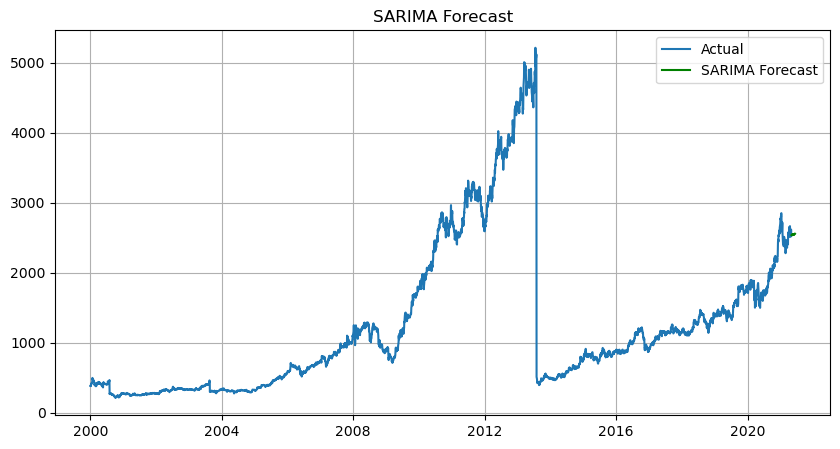

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = P = D = Q = range(0, 2)
s = [12]  # Monthly

params = list(itertools.product(p, d, q, P, D, Q, s))
best_score = float("inf")
best_cfg = None

for param in params:
    try:
        model = SARIMAX(df['Close'],
                        order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]))
        result = model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_cfg = param
    except:
        continue

print("Best SARIMA order:", best_cfg)
model_sarima = SARIMAX(close_data, order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit()
forecast_sarima = model_sarima_fit.forecast(steps=30)
plt.figure(figsize=(10, 5))
plt.plot(close_data, label='Actual')
plt.plot(pd.date_range(close_data.index[-1], periods=31, freq='B')[1:], forecast_sarima, label='SARIMA Forecast', color='green')
plt.legend()
plt.title('SARIMA Forecast')
plt.grid()

plt.show()

00:48:51 - cmdstanpy - INFO - Chain [1] start processing
00:48:54 - cmdstanpy - INFO - Chain [1] done processing


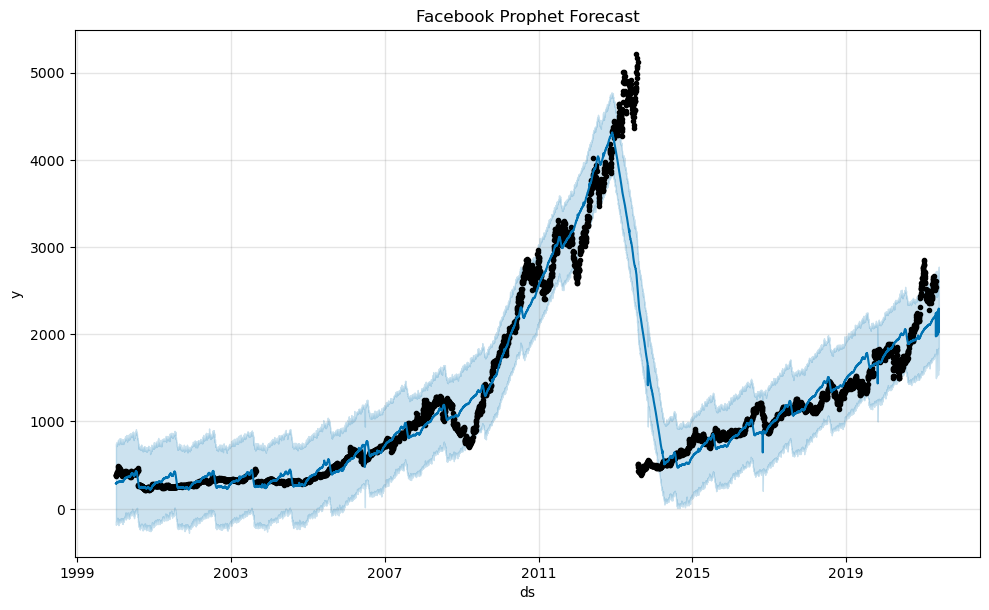

In [10]:
# Prophet needs columns as ds (date) and y (value)
df_prophet = close_data.reset_index().rename(columns={"Date": "ds", "Close": "y"})

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=30)
forecast_prophet = model_prophet.predict(future)

# Plot
model_prophet.plot(forecast_prophet)
plt.title('Facebook Prophet Forecast')
plt.show()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - loss: 0.0100
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 7.9176e-04
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 4.3719e-04
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 4.7542e-04
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 7.0301e-04
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 3.3526e-04
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 6.8188e-04
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 7.7799e-04
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 1.5530e-04
Epoch 10/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 2.1146e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

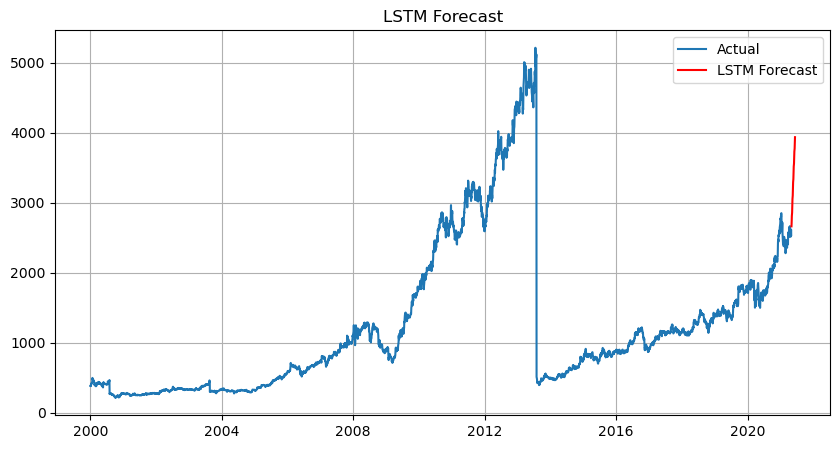

In [11]:
# Preprocess
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data.values.reshape(-1, 1))

X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=32)

# Forecast
last_60 = scaled_data[-60:]
predictions = []

for _ in range(30):
    inp = last_60.reshape((1, 60, 1))
    pred = model.predict(inp)[0, 0]
    predictions.append(pred)
    last_60 = np.append(last_60[1:], [[pred]], axis=0)

# Inverse transform
forecast_lstm = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(close_data, label='Actual')
plt.plot(pd.date_range(close_data.index[-1], periods=31, freq='B')[1:], forecast_lstm, label='LSTM Forecast', color='red')
plt.legend(); plt.title('LSTM Forecast'); plt.grid(); plt.show()
